In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

import scores

from scipy.ndimage import maximum_filter

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""

    where am i?

"""

PATH = os.getcwd()
precomputed_path = PATH + '/precomputed/'

print( f'PATH: { PATH }' )
print( f'precomputed path: { precomputed_path }' )

PATH: /Users/no_lineal/Documents/GitHub/dm-grid-cells
precomputed path: /Users/no_lineal/Documents/GitHub/dm-grid-cells/precomputed/


In [4]:
""" 

    load dataset

"""

res_lst = sorted( [ x for x in os.listdir( precomputed_path + 'res/' ) if '.npy' in x] )
res_lst = [ np.load( precomputed_path + 'res/' + x, allow_pickle=True, encoding='latin1' ) for x in res_lst ]

scores_lst = sorted( [ x for x in os.listdir( precomputed_path + 'scores/' ) if '.npy' in x ] )
scores_lst = [ np.load( precomputed_path + 'scores/' + x, allow_pickle=True, encoding='latin1' ) for x in scores_lst ]

print( f'res_lst: { len(res_lst) }' )
print( f'scores_lst: { len(scores_lst) }' )

res_lst: 1
scores_lst: 1


In [5]:
"""  

    sample

"""

sample_res = np.random.choice( res_lst, 1 )
sample_res = dict( sample_res[0].item() )

sample_res.keys()
print( f'sample lstm: { sample_res["lstm"].shape }' )
print( f'sample bootleneck: { sample_res["bottleneck"].shape }' )
print( f'sample pos_xy: { sample_res["pos_xy"].shape }' )

sample lstm: (4000, 100, 128)
sample bootleneck: (4000, 100, 512)
sample pos_xy: (4000, 100, 2)


In [6]:
""" 

    get scores

"""

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())

coord_range = ( (-1.1, 1.1), (-1.1, 1.1) )

latest_epoch_scorer = scores.GridScorer(50, coord_range, masks_parameters)

# concatenate trajectories
xy = sample_res['pos_xy'].reshape(-1, sample_res['pos_xy'].shape[-1])
act = sample_res['bottleneck'].reshape(-1, sample_res['bottleneck'].shape[-1])
n_units = act.shape[1]

# get ratemap for each unit
s = [ latest_epoch_scorer.calculate_ratemap(xy[:, 0], xy[:, 1], act[:, i]) for i in tqdm(range(n_units)) ]

# Get the scores
score_60, score_90, max_60_mask, max_90_mask, sac = zip( * [ latest_epoch_scorer.get_scores(rate_map) for rate_map in tqdm(s) ] )

print( f'xy: { xy.shape }' )
print( f'act: { act.shape }' )
print( f'n_units: { n_units }' )
print('')
print( f'score_60: { len(score_60) }' )
print( f'score_90: { len(score_90) }' )
print( f'max_60_mask: { len(max_60_mask) }' )
print( f'max_90_mask: { len(max_90_mask) }' )
print( f'sac: { len(sac) }' )

100%|██████████| 512/512 [01:41<00:00,  5.03it/s]

xy: (400000, 2)
act: (400000, 512)
n_units: 512

score_60: 512
score_90: 512
max_60_mask: 512
max_90_mask: 512
sac: 512


In [7]:
""" 

    peak filter

"""

def peak_filter( sac ):

    global_max = []
    local_max = []

    for s in tqdm(sac):
        
        global_max_pos = np.unravel_index( s.argmax(), s.shape )
        local_max_pos = maximum_filter(s, footprint=np.ones((10, 10)), mode='constant')

        global_max.append( global_max_pos )
        local_max.append( local_max_pos )

    return global_max, local_max

sac = np.array( sac )
global_max, local_max = peak_filter( sac )

print( f'sac: { sac.shape }' )
print( f'global_max: { len(global_max) }' )
print( f'local_max: { len(local_max) }' )

100%|██████████| 512/512 [00:00<00:00, 5665.15it/s]

sac: (512, 99, 99)
global_max: 512
local_max: 512


idx_sample: 45


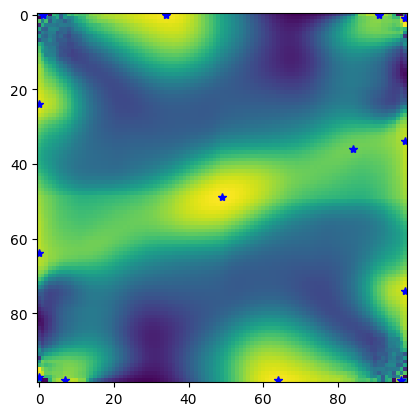

In [8]:
"""  

    sac sample

"""

idx_sample = np.random.choice( range(len(sac)) )
idx_sample = 45
sac_sample = sac[ idx_sample ]
global_sample = global_max[ idx_sample ]
local_sample = local_max[ idx_sample ]
local_sample = np.argwhere( local_sample == sac_sample )

print( f'idx_sample: { idx_sample }' )

plt.imshow( sac_sample )
plt.plot( global_sample[1], global_sample[0], 'r*' )
plt.plot( local_sample[:,1], local_sample[:,0], 'b*' )

plt.show()